# 3F8 Binary Classifier #

This notebook is my implementation of the 3F8 coursework. A few of the plotting functions are adapted versions of those provided in the supplementary code.


## The Data ##

We start by importing the required modules as well as the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
import sklearn.metrics as skme

In [2]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

In [3]:
X.shape

(1000, 2)

In [4]:
Y.shape

(1000,)

The data consist of 1000 2D data points, X, and 1000 associated labels, Y.

In [5]:
np.unique(Y)

array([0., 1.])

As expected, the data is binary, i.e. there are two classes.

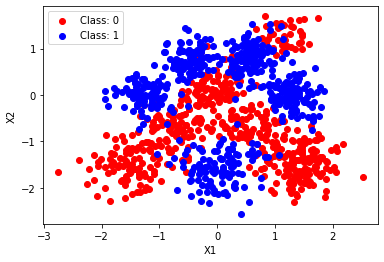

In [6]:
def plot_classes_2D(x, y, c):
    """
        Produces a labelled scatter plot of 2D data
        
        Inputs: X - an (Nx2) array of datapoints
                Y - a length N array of associated labels
                c - a length 2 array of matplotlib colour codes
                
        Outputs: None
    """
    ax = plt.gca()
    for index, label in enumerate(np.unique(y)):
        x1 = [x[i,0] for i in range(x.shape[0]) if y[i] == label]
        x2 = [x[j,1] for j in range(x.shape[0]) if y[j] == label]
        ax.scatter(x1, x2, c=colours[index], label='Class: '+str(int(label)))
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

colours = ['r', 'b']
plot_classes_2D(X, Y, colours)

The data clearly has a very non-linear decision boundary, and so a logistic regression using only the linear input data is unlikely to perform well.

## Training a basic logistic model ##
First we define some useful functions for the training

In [7]:
def logistic(z):
    """
        Sigmoid function
        
        Inputs: z - a numerical input to the function
        Output: sigmoid
    """
    return 1. / (1. + np.exp(-1*z))

def create_X_tilde(x):
    """
        Prepends a column of 1's to the array X
        
        Inputs: x - array of 2D data to form x_tilde
        Output: x_tilde
    """
    ones = np.ones((x.shape[0], 1))
    return np.concatenate((ones, x), axis=1)

def calc_grad(beta, x, y):
    """
    Computes the numerical expression derived elsewhere for the grad of the log-likelihood

    Inputs: beta - current weight values
            x - x_tilde, i.e. data array x with column of 1's prepended
            y - class labels for x
    Output: Grad
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(x.T, (np.multiply(y, 1-sigmas) - np.multiply(1-y, sigmas)))

def calc_likelihood(beta, x, y):
    """
        Computes the numerical expression derived elsewhere for the log-likelihood
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
        Output: log-likelihood
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(y.T, sigmas) + np.dot((1-y).T, (1-sigmas).T)

  

We use scikitlearn to randomly split the data for testing purposes

In [8]:
X_train, X_test, Y_train, Y_test = skms.train_test_split(X, Y, train_size=0.8)
X_tilde_train = create_X_tilde(X_train)
X_tilde_test = create_X_tilde(X_test)

The basic process for training our beta is gradient ascent. We update beta after each iteration to be it's old value plus the scaled grad at that location

In [10]:
learning_rate = 0.0001
steps = 1000
def train_model(x_tilde_train, y_train, x_tilde_test, y_test, alpha, n):
    beta = np.random.normal(size=x_tilde_train.shape[1])
    lls_train = np.ones(n)
    lls_test = np.ones(n)
    for i in range(n):
        beta = beta + alpha * calc_grad(beta, x_tilde_train, y_train)
        ll_train = calc_likelihood(beta, x_tilde_train, y_train)/X_tilde_train.shape[0]
        lls_train[i] = ll_train
        ll_test = calc_likelihood(beta, x_tilde_test, y_test)/X_tilde_test.shape[0]
        lls_test[i] = ll_test
    return beta, lls_train, lls_test

The choice of learning_rate and steps have largely been trial and error. If the learning rate is too small then beta never converges, if it is too large then it tends to oscillate.
Additionally if we choose to use too many steps then beta tends to grow unbouded. This is because in each iteration we add a very small term to beta (which will be non-zero when our choice of learning rate is not good enough). A possible improvement to this is to add a regularisation term to the log-likelihood

In [11]:
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
def plot_likelihoods(ll_train, ll_test, n):
    axis = np.arange(n)
    plt.plot(axis, ll_train, label='Train')
    plt.plot(axis, ll_test, label='Test')
    plt.xlabel('Iterations')
    plt.ylabel('Average log-likelihood')
    plt.legend(loc='right')

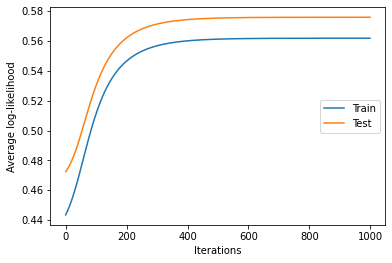

In [12]:
plot_likelihoods(likelihoods_train, likelihoods_test, steps)

The log-likelihood converges well.

In [13]:
betas

array([ 0.36120471, -0.10939333,  0.76196606])

In [14]:
def plot_predictive_distribution(x, y, betas, map_inputs = lambda x : x):
    plot_classes_2D(x, y, colours)
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    new_x_tilde = create_X_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = logistic(np.dot(new_x_tilde, betas))
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

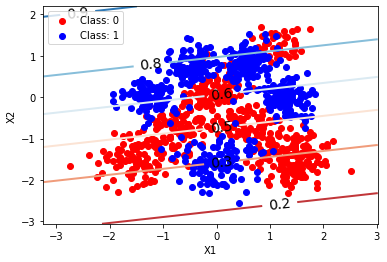

In [15]:
plot_predictive_distribution(X, Y, betas)

The logistic regression performs moderately. It is unable to properly explain the lower class 1 group and so seems to ignore it.

In [16]:
def predict(X_tilde, beta):
    return logistic(np.dot(X_tilde, beta))

def decision(probs):
    return np.array([prob>0.5 for prob in probs]).astype(int)

In [17]:
predictions = predict(create_X_tilde(X_test), betas)
decisions = decision(predictions)

In [18]:
def confusion_matrix(y_true, y_pred):
    return skme.confusion_matrix(y_true, y_pred)

In [19]:
confusion_matrix(Y_test, decisions)/Y_test.shape

array([[0.39 , 0.175],
       [0.115, 0.32 ]])

## Radial Basis Functions ##

In [20]:
def evaluate_basis_functions(l, X, Z):
        X_sq = np.sum(X**2, 1) # length N array of sum of squares of each row
        Z_sq = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])

        distance = np.outer(X_sq, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z_sq)
        return np.exp(-(0.5 / l**2) * distance)

def metrics(lls_train, lls_test, beta, n, x, x_train, x_test, y, y_test, l):
    plot_likelihoods(lls_train, lls_test, n)
    plt.show()
    plot_predictive_distribution(x, y, beta, lambda x : evaluate_basis_functions(l, x, x_train))
    plt.show()
    decisions = decision(predict(create_X_tilde(evaluate_basis_functions(l, x_test, x_train)), beta))
    print(confusion_matrix(y_test, decisions)/y_test.shape)

In [21]:
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))

NameError: name 'l' is not defined

el = 0.01

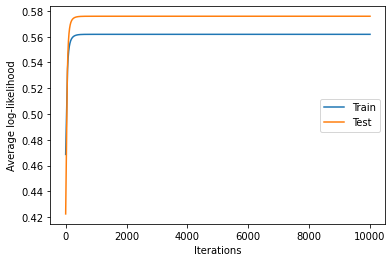

ValueError: shapes (10000,801) and (3,) not aligned: 801 (dim 1) != 3 (dim 0)

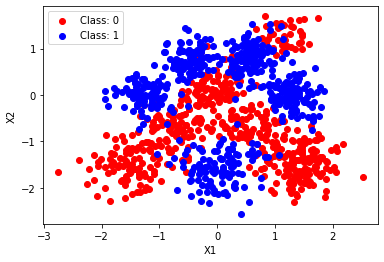

In [22]:
l = 0.01
learning_rate = 0.0001
steps = 10000
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

With l=0.01, the length scale for the Gaussian RBF is arguably too small. The model is fitting to individual data points and cannot caputre the behaviour of the classes as a whole. Strangely, the model produces a significant amount of false negatives.

el = 0.1

In [ ]:
l = 0.1
learning_rate = 0.0001
steps = 1000
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

l=0.1 seems to be a better length scale. The contours encircle clusters of points, rather than individual points. The model does, however, still seem to overfit the training data, likely due to the lack of regularisation. The confusion matrix shows that roughly 60% of test points were correctly labelled.

In [ ]:
l = 1
learning_rate = 0.0001
steps = 5000
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

This time, the length scale (l=1) is about right. The probability contours follow the heuristic boundaries nicely, the train and test likelihoods seems quite close and the confusion matrix shows the classifier is ~90% accurate.